In [1]:
import numpy as np  # mathematical operations on arrays and matrices
import pandas as pd # data manipulation and analysis
import seaborn as sns # data visualization and plotting
import warnings 
warnings.filterwarnings("ignore") # ignoring any warnings that may occur during the analysis
from matplotlib import pyplot as plt # creating visualizations and plots
%matplotlib inline 
# magic command for Jupyter Notebook that allows the plots to be displayed inline within the notebook.

import pandas_datareader.data as web # accessing to various financial data sources
import datetime as dt # providing classes and functions for working with dates and times 
import yfinance as yf # Python wrapper for the Yahoo Finance API

from sklearn.preprocessing import MinMaxScaler # performing feature scaling to normalize the data between 0 and 1
from tensorflow.keras.models import Sequential # defining a linear stack of layers for building a neural network model
from tensorflow.keras.layers import LSTM, Dense # representing specific types of layers (LSTM and dense, respectively) used in the neural network architecture.

In [2]:
ticker = yf.Ticker('NAS.OL').info
market_price = ticker['ask']
previous_close_price = ticker['regularMarketPreviousClose']
print('Ticker: NAS.OL')
print('Market price:', market_price)
print('Previous close price:', previous_close_price)

Ticker: NAS.OL
Market price: 12.265
Previous close price: 11.88


In [3]:
# Setting the start and end date
start_date = '2016-01-01'
end_date = '2023-01-01'

# Setting the ticker
ticker = 'NAS.OL'
# Getting the data using ticker for the mentioned dates
norgeair = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
# assigning the index values of the norgeair DataFrame to a new column named "Date"
norgeair["Date"] = norgeair.index
norgeair = norgeair[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
# resetting the index of the DataFrame after making changes
norgeair.reset_index(drop=True, inplace=True)

In [5]:
# Exporting data to a CSV file
norgeair.to_csv("nas.csv")

In [6]:
# reading the data from the CSV file "nas.csv" into a pandas DataFrame called nas_df
nas_df = pd.read_csv("nas.csv", index_col='Date', parse_dates=True)
# converting the index of the DataFrame nas_df to datetime format
nas_df.index = pd.to_datetime(nas_df.index)
# resampling the nas_df DataFrame at a monthly frequency ('MS') and calculates the mean of each month
nas_monthly = nas_df.resample('MS').mean()

In [7]:
nas_monthly.drop(['Unnamed: 0'], axis=1, inplace= True)

In [8]:
# creating a dataframe called 'df' with only attribute 'close'
df = nas_monthly[['Close']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [10]:
train = df.iloc[:70] # selecting the first 70 rows of the DataFrame df and assigns them to the variable train.
test = df.iloc[70:] # selecting all rows starting from the 70th row until the end of the DataFrame df and assigns them to the variable test.

In [11]:
# reading first few rows of the train 
train.head()

,Close
Date,
2016-01-01,15696.631348
2016-02-01,15259.055013
2016-03-01,17635.749805
2016-04-01,20183.437128
2016-05-01,19992.590563


In [48]:
# reading first few rows of the test
test.head()

,Close
Date,
2021-11-01,10.897182
2021-12-01,9.827619
2022-01-01,11.727810
2022-02-01,12.210200
2022-03-01,10.241870


In [15]:
scaler = MinMaxScaler() #  creating an instance of the MinMaxScaler class and assigns it to the variable scaler.
scaler.fit(train) # fitting the scaler object to the data in the train variable, calculating the minimum and maximum values of the data.
# transforming the data in the train variable using the scaling parameters, and assigns the scaled data to the variable scaled_train.
scaled_train = scaler.transform(train) 

In [16]:
scaled_test = scaler.transform(test)

In [17]:
scaled_train[:10]

array([[0.77759231],
       [0.75590197],
       [0.873713  ],
       [1.        ],
       [0.99053987],
       [0.91892967],
       [0.82794461],
       [0.87548302],
       [0.85193818],
       [0.81110049]])

In [18]:
scaled_test[:10]

array([[ 6.18939953e-05],
       [ 8.87654869e-06],
       [ 1.03067609e-04],
       [ 1.26979354e-04],
       [ 2.94106460e-05],
       [ 1.00752803e-04],
       [ 6.50499740e-05],
       [-3.28208999e-06],
       [-2.62657054e-05],
       [-6.91286033e-06]])

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator
# We do the same thing, but now instead for 12 months
n_input = 12 # This variable specifies the number of previous time steps to use as input to predict the next time step in the time series. 
# In this case, we are using 12 previous time steps.
n_features = 1 # This variable specifies the number of features in the time series. 
# In this case, we have only one feature (i.e., univariate time series).
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=10)

In [20]:
# defining model
from tensorflow.keras.optimizers import Adam
model = Sequential()
# LSTM layer with 100 units and ReLU activation function is added to the model, with input data with a shape of (n_input, n_features)
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features))) 
# Two dense layers with 64 and 32 units, respectively, and ReLU activation functions are added to the model.
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# final dense layer with 1 unit is added, representing the output layer.
model.add(Dense(1))
#  model is compiled with the Adam optimizer using a learning rate of 0.001, mean squared error (MSE) loss function, and mean absolute error (MAE) metric.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [21]:
# fitting the model
model.fit(generator,epochs=75)

Epoch 1/75
6/6 [==============================] - 5s 28ms/step - loss: 0.1301 - mae: 0.2619
Epoch 2/75
6/6 [==============================] - 0s 19ms/step - loss: 0.0570 - mae: 0.1825
Epoch 3/75
6/6 [==============================] - 0s 18ms/step - loss: 0.0315 - mae: 0.1579
Epoch 4/75
6/6 [==============================] - 0s 44ms/step - loss: 0.0211 - mae: 0.1282
Epoch 5/75
6/6 [==============================] - 0s 32ms/step - loss: 0.0233 - mae: 0.1337
Epoch 6/75
6/6 [==============================] - 0s 29ms/step - loss: 0.0122 - mae: 0.0889
Epoch 7/75
6/6 [==============================] - 0s 40ms/step - loss: 0.0119 - mae: 0.0873
Epoch 8/75
6/6 [==============================] - 0s 24ms/step - loss: 0.0112 - mae: 0.0726
Epoch 9/75
6/6 [==============================] - 0s 20ms/step - loss: 0.0097 - mae: 0.0653
Epoch 10/75
6/6 [==============================] - 0s 42ms/step - loss: 0.0115 - mae: 0.0709
Epoch 11/75
6/6 [==============================] - 0s 31ms/step - loss: 0.0082 

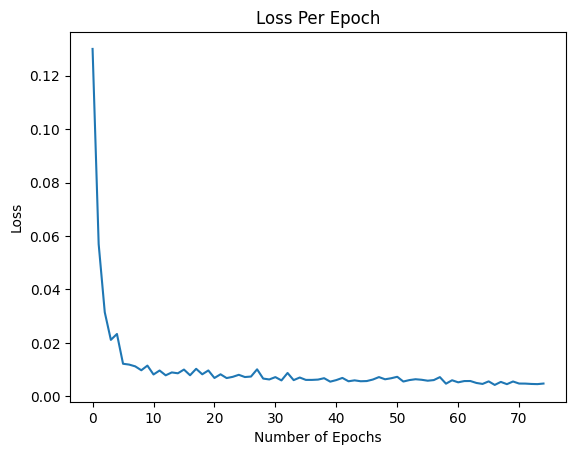

In [22]:
# loss_per_epoch = model.history.history['loss'] retrieves the training loss values from the dictionary and stores them in the loss_per_epoch variable.
# The code plt.plot(range(len(loss_per_epoch)),loss_per_epoch) uses the matplotlib library to plot the training loss values against the number of epochs. 
# The range(len(loss_per_epoch)) generates a sequence of numbers that correspond to the epochs, and loss_per_epoch provides the loss values at each epoch. 
# The resulting plot shows the trend of the training loss over the epochs.
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Per Epoch')
plt.show()

In [23]:
# Preparing the last 12 months of the training set for prediction
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

# Making predictions for the next 12 months using the trained LSTM model
predictions = []
for i in range(12):
    prediction = model.predict(last_train_batch)[0]
    predictions.append(prediction)
    last_train_batch = np.append(last_train_batch[:,1:,:], [[prediction]], axis=1)

1/1 [==============================] - 0s 25ms/step


In [24]:
# Applying inverse transform the predictions to get the predicted stock prices in their original scale
predictions = scaler.inverse_transform(predictions)

In [25]:
print(predictions)

[[14.75776191]
 [14.85065129]
 [14.9190783 ]
 [14.97025764]
 [14.99139448]
 [15.00231049]
 [15.00841669]
 [15.00858578]
 [14.9950582 ]
 [14.98464948]
 [14.97540564]
 [14.96691332]]


In [26]:
# creating a new variable last_train_batch that stores the last 12 values of the scaled_train array.
newlast_train_batch = scaled_train[-12:]

In [27]:
# 
last_train_batch1 = newlast_train_batch.reshape((1, n_input, n_features))

In [28]:
model.predict(last_train_batch1)

1/1 [==============================] - 0s 30ms/step


array([[0.00025326]], dtype=float32)

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# The loop iterates over the length of the test dataset. In each iteration:
for i in range(len(test)):
    
    # current_pred represents the prediction value obtained by passing the current_batch through the model using the model.predict() method
    current_pred = model.predict(current_batch)[0]
    
    # The current_pred is then appended to the test_predictions list
    test_predictions.append(current_pred) 
    
    # current_batch is updated by removing the first value and adding the current_pred at the end
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [30]:
print(test_predictions)

[array([0.00025326], dtype=float32), array([0.00025786], dtype=float32), array([0.00026126], dtype=float32), array([0.00026379], dtype=float32), array([0.00026484], dtype=float32), array([0.00026538], dtype=float32), array([0.00026568], dtype=float32), array([0.00026569], dtype=float32), array([0.00026502], dtype=float32), array([0.00026451], dtype=float32), array([0.00026405], dtype=float32), array([0.00026363], dtype=float32), array([0.00026332], dtype=float32), array([0.0002633], dtype=float32)]


In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
print(true_predictions)

[[14.75776191]
 [14.85065129]
 [14.9190783 ]
 [14.97025764]
 [14.99139448]
 [15.00231049]
 [15.00841669]
 [15.00858578]
 [14.9950582 ]
 [14.98464948]
 [14.97540564]
 [14.96691332]
 [14.96063803]
 [14.96026226]]


In [36]:
true_predictions.shape

(14, 1)

In [37]:
test.shape

(14, 1)

In [38]:
# Calculating the evaluation metrics
mse = np.mean((true_predictions - test) ** 2)
mae = np.mean(np.abs(true_predictions - test))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: Close    28.78937
dtype: float64
Mean Absolute Error: Close    5.142869
dtype: float64


In [39]:
# Calculating R2 score
from sklearn.metrics import r2_score
r2 = r2_score(test, true_predictions)
print("R2 Score:", r2)

R2 Score: -11.49890130405688


The MSE for the predicted close prices is 28.78937. The MSE measures the average squared difference between the predicted and actual values. A lower MSE indicates better accuracy and closeness of the predictions to the actual values. However, the interpretation of MSE values can vary depending on the scale of the data. It is important to compare the MSE to the range of the data to assess its magnitude.

The MAE for the predicted close prices is 5.142869. The MAE represents the average absolute difference between the predicted and actual values. Like MSE, a lower MAE suggests better accuracy. MAE is easier to interpret than MSE as it is in the same unit as the original data.

However, the R2 score is a statistical measure that indicates the proportion of the variance in the dependent variable (close prices) that can be explained by the independent variable (predictions). An R2 score of -11.49890130405688 indicates that the predictions do not explain the variance in the close prices well and are performing poorly. A negative R2 score suggests that the model's predictions are worse than simply using the mean of the dependent variable. It indicates a poor fit of the model to the data.

Overall, based on these evaluation metrics, it appears that the predictions made by the model are not accurate and do not capture the patterns in the close prices effectively. Further analysis and improvement of the model may be necessary to achieve better results. *italicized text*

In [40]:
print(test)

                Close
Date                 
2021-11-01  10.897182
2021-12-01   9.827619
2022-01-01  11.727810
2022-02-01  12.210200
2022-03-01  10.241870
2022-04-01  11.681111
2022-05-01  10.960850
2022-06-01   9.582333
2022-07-01   9.118667
2022-08-01   9.509087
2022-09-01   7.327000
2022-10-01   7.308667
2022-11-01   8.602818
2022-12-01   8.356000


In [45]:
# Create a copy of the test data
test_with_predictions = test.copy()

# Adding the predicted values to the test data
test_with_predictions['Predicted'] = true_predictions

In [46]:
test_with_predictions.head()

,Close,Predicted
Date,,
2021-11-01,10.897182,14.757762
2021-12-01,9.827619,14.850651
2022-01-01,11.727810,14.919078
2022-02-01,12.210200,14.970258
2022-03-01,10.241870,14.991394


<Axes: xlabel='Date'>

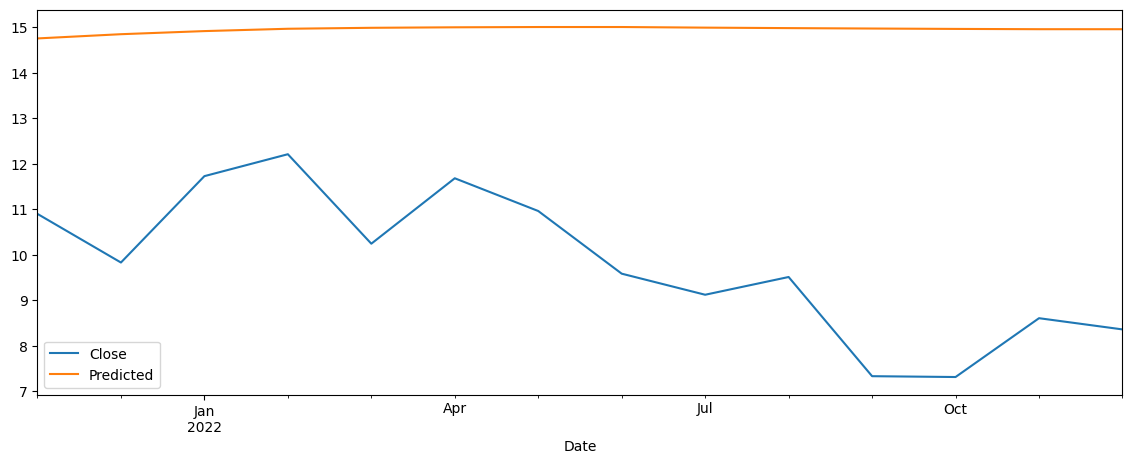

In [47]:
# plotting the graph of predicted and actual data
test_with_predictions.plot(figsize=(14,5))